In [1]:
import scipy
import scipy.sparse.linalg as linalg
import numpy as np
import matplotlib.pyplot as plt
import jax
import jax.numpy as jnp
from jax.numpy.fft import fft, ifft, fftfreq
from jax import jit

from jax.config import config
config.update("jax_enable_x64", True)

# simulation grid
nu = 1
L = 35
nx = 1024//4
nt = 4000//4

# initial conditions used for demo
T  = 300
x = np.linspace( 0, L,  nx)
u0 = np.cos((2 * np.pi * x) / L) + 0.1 * np.cos((4 * np.pi * x) / L)

simulation_params = {'nu': nu, 'L': L, 'nx': nx, 'nt': nt}

# plot the result
def plot_KS(u,T,nx=nx,nt=nt):
    x = np.linspace( 0, L, nx)
    t = np.linspace( 0, T, nt)
    fig, ax = plt.subplots(figsize=(10,8))

    xx, tt = np.meshgrid(x, t)
    levels = np.linspace(-3.5, 3.5, 300)
    cs = ax.contourf(xx, tt, u, levels)
    fig.colorbar(cs)

    ax.set_xlabel("x")
    ax.set_ylabel("t")
    ax.set_title(f"Kuramoto-Sivashinsky: L = {L}, nu = {nu}")

In [2]:
def construct_integrator(nu, L, nx, nt):
  @jit
  def propagator(u0, T):
    dt = T/nt
    # wave number mesh (multiply back by nx because fftfreq takes it out - we raise k to powers so it affects us and has to be accounted for)
    k = (2 * jnp.pi / L) * fftfreq(nx) * nx

    # solution mesh in real and Fourier space
    u      = jnp.empty((nt, nx), dtype=jnp.float64)
    u_hat  = jnp.empty((nt, nx), dtype=jnp.complex128)
    u_hat2 = jnp.empty((nt, nx), dtype=jnp.complex128)

    # set initial condition in real and Fourier space
    u      = u     .at[0].set( u0 )
    u_hat  = u_hat .at[0].set( (1 / nx) * fft(u[0])    )
    u_hat2 = u_hat2.at[0].set( (1 / nx) * fft(u[0]**2) )

    # Fourier Transform of the linear and nonlinear operators
    FL = (k ** 2) - nu * (k ** 4)
    FN = - (1 / 2) * (1j) * k

    # Crank-Nicholson algebraic relations between uhat[n+1] and uhat[n]
    CN1 = (1 + (dt / 2) * FL)
    CN2 = 1 / (1 - (dt / 2) * FL)

    # first timestep (no advanced restarting, just Euler)
    u_hat  = u_hat .at[1].set( CN2 * ( CN1 * u_hat[0] + FN * u_hat2[0] * dt) )

    # auxiliaries of first timestep
    u      = u     .at[1].set( nx * jnp.real(ifft(u_hat[1])) )
    u_hat2 = u_hat2.at[1].set( (1 / nx) * fft(u[1]**2)       )

    # compute solution through time via finite difference method in Fourier space
    def finite_step(j, state):
        u, u_hat, u_hat2 = state
        # Cranck-Nicholson + Adams-Bashforth
        u_hat  = u_hat.at[j+1].set( CN2 * ( CN1 * u_hat[j] + ( 1.5 * FN * u_hat2[j] - 0.5 * FN * u_hat2[j-1] ) * dt) )
        
        # go back to real space
        u      = u     .at[j+1].set( nx * jnp.real(ifft(u_hat[j+1])) )
        u_hat2 = u_hat2.at[j+1].set( (1 / nx) * fft(u[j+1]**2)       )
        return (u, u_hat, u_hat2)

    # compute solution through time via finite difference method in Fourier space
    u = jax.lax.fori_loop(1,nt-1,finite_step,(u, u_hat, u_hat2))[0]
    return jnp.real(u)
  
  return propagator

JAX_propagator = construct_integrator(**simulation_params)
u = JAX_propagator(u0,T)

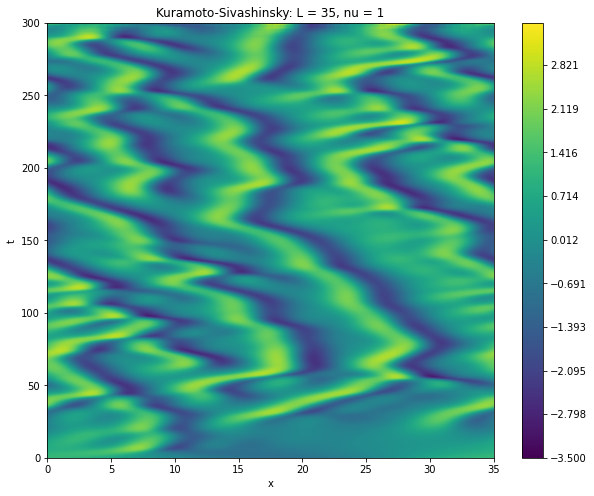

In [3]:
plot_KS(u,T)

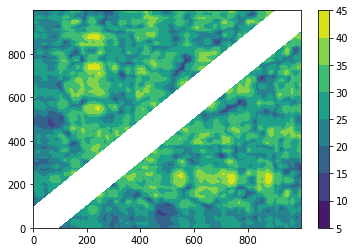

In [4]:
diff = np.linalg.norm(u[:,np.newaxis] - u[np.newaxis,:],axis=-1)
x, y = np.mgrid[0:1:(1j*nt),0:1:(1j*nt)]
diff[abs(x-y)<0.1] += np.inf
plt.contourf(diff)
plt.colorbar()

7.654376833146577
550 727


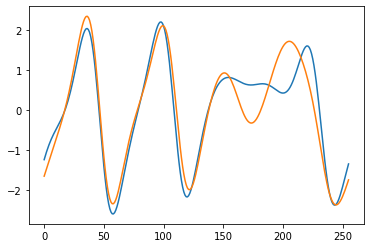

In [5]:
a = np.argmin(diff) % nt
b = np.argmin(diff) // nt
a, b = min(a,b), max(a,b)
plt.plot(u[a])
plt.plot(u[b])
print(np.linalg.norm(u[a] - u[b]))
print(a,b)

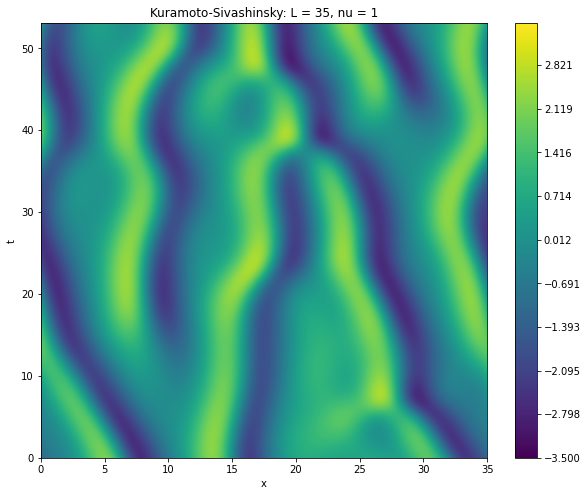

In [6]:
new_T = T * (b-a)/nt
u_new = JAX_propagator(u[a],new_T)
plot_KS(u_new, new_T)

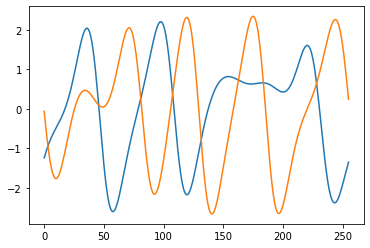

In [7]:
plt.plot(u_new[0])
plt.plot(u_new[-1])

In [8]:
@jit
def residual(state):
    T, u0 = state[0], state[1:]
    prop  = JAX_propagator(u0,T)
    state = jnp.zeros((u0.shape[0] + 1,))
    state = state.at[0].set(0)
    state = state.at[1:].set(prop[0] - prop[-1])
    return state

def State(u0, T):
    state = jnp.zeros((u0.shape[0] + 1,))
    state = state.at[0].set(T)
    state = state.at[1:].set(u0)
    return state

In [9]:
@jit
def residual(u0):
    return u0 - JAX_propagator(u0,new_T)[-1]

In [10]:
def JAX_newton_krylov(res, u0, tol=1e-5, iter=200):
    u = u0
    Jacobian_shape = (len(u0.flatten()), len(u0.flatten()))

    F = res(u)
    magF = np.linalg.norm(F)
    print(f"|F(x)| = {magF}")
    i = 1
    while magF > tol and i < iter:
        J = linalg.LinearOperator(Jacobian_shape, matvec=lambda v: (jax.jvp(res, (u.flatten(),), (v,)))[1])
        f, e = linalg.lgmres(J,F.flatten(),inner_m=40,outer_k=20)
        step = f.reshape(u.shape) * 0.01
        step = step if np.linalg.norm(step) < 0.01 * np.linalg.norm(u) else 0.01 * np.linalg.norm(u) * step / np.linalg.norm(step)
        u -= step
        F = res(u)
        magF = np.linalg.norm(F)
        print(f"{i}: |F(x)| = {magF:.10f}, |step| = {np.linalg.norm(step):.5f}, |u| = {np.linalg.norm(u):.5f}")
        i += 1
    return u

# solve
guess = u[a] #State(u[a],new_T)
sol = JAX_newton_krylov(residual,guess)
print('Residual', abs(residual(sol)).max())

|F(x)| = 37.8736621432547


C:\Users\kowal\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:11: DeprecationWarning: scipy.sparse.linalg.lgmres called without specifying `atol`. The default value will change in the future. To preserve current behavior, set ``atol=tol``.
  # This is added back by InteractiveShellApp.init_path()


1: |F(x)| = 37.6800794592, |step| = 0.20747, |u| = 20.61762
2: |F(x)| = 37.4880439432, |step| = 0.20618, |u| = 20.48843
3: |F(x)| = 37.2976915547, |step| = 0.20488, |u| = 20.35957
4: |F(x)| = 37.1090794898, |step| = 0.20360, |u| = 20.23155
5: |F(x)| = 36.9222076552, |step| = 0.20232, |u| = 20.10496
6: |F(x)| = 36.7370415775, |step| = 0.20105, |u| = 19.98047
7: |F(x)| = 36.5535433759, |step| = 0.19980, |u| = 19.85894
8: |F(x)| = 36.3717223043, |step| = 0.19859, |u| = 19.74148
9: |F(x)| = 36.1917284916, |step| = 0.19741, |u| = 19.62971
10: |F(x)| = 36.0140406042, |step| = 0.19630, |u| = 19.52593
11: |F(x)| = 35.8398515632, |step| = 0.19526, |u| = 19.43364
12: |F(x)| = 35.6718234846, |step| = 0.19434, |u| = 19.35804
13: |F(x)| = 35.5152616867, |step| = 0.19358, |u| = 19.30619
14: |F(x)| = 35.3787023659, |step| = 0.19306, |u| = 19.28548
15: |F(x)| = 35.2710243138, |step| = 0.19285, |u| = 19.29934
16: |F(x)| = 35.1955051805, |step| = 0.19299, |u| = 19.34437
17: |F(x)| = 35.1486014513, |step

In [11]:
RPO = JAX_propagator(sol,new_T)

53.1


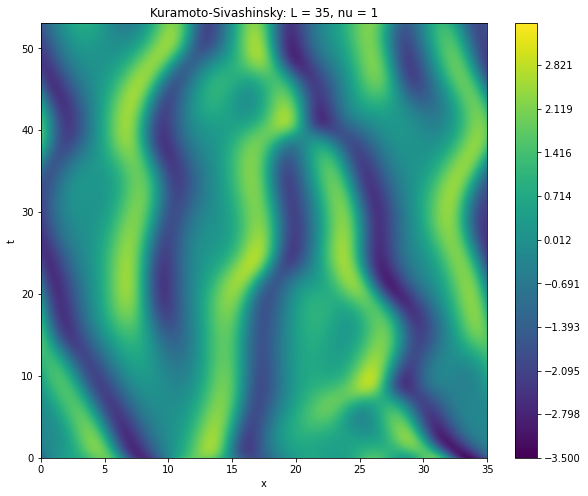

In [12]:
print(new_T)
plot_KS(RPO, new_T)

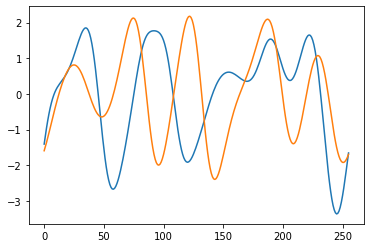

In [13]:
plt.plot(RPO[0])
plt.plot(RPO[-1])

8.840264377535238
496 596


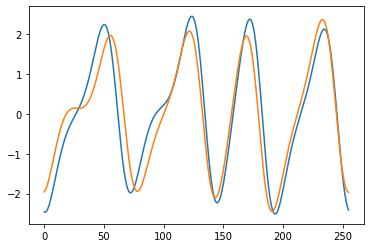

In [14]:
diff = np.linalg.norm(RPO[:,np.newaxis] - RPO[np.newaxis,:],axis=-1)
x, y = np.mgrid[0:1:(1j*nt),0:1:(1j*nt)]
diff[abs(x-y)<0.1] += np.inf
a = np.argmin(diff) % nt
b = np.argmin(diff) // nt
a, b = min(a,b), max(a,b)
plt.plot(RPO[a])
plt.plot(RPO[b])
print(np.linalg.norm(RPO[a] - RPO[b]))
print(a,b)

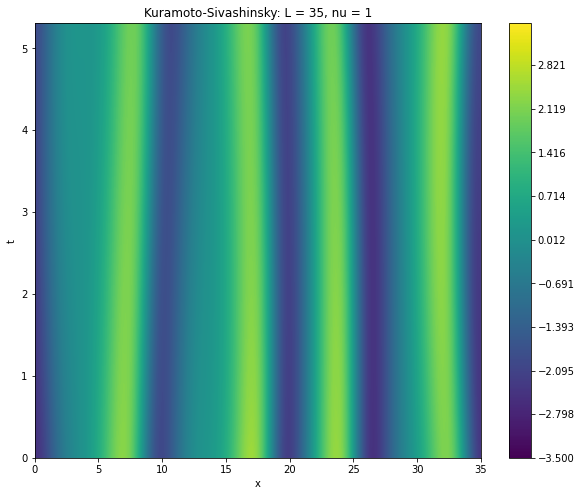

In [15]:
T_new = new_T * (b-a)/nt
u_new = JAX_propagator(RPO[a],T_new)
plot_KS(u_new, T_new)

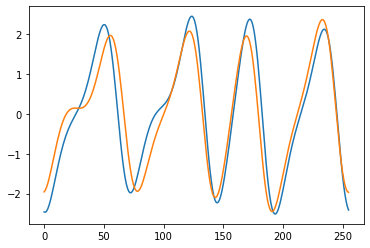

In [16]:
plt.plot(u_new[0])
plt.plot(u_new[-1])

In [17]:
@jit
def residual(u0):
    return u0 - JAX_propagator(u0,T_new)[-1]

# solve
guess = RPO[a] #State(u[a],new_T)
sol = JAX_newton_krylov(residual, guess)
print('Residual', abs(residual(sol)).max())

|F(x)| = 8.833285248114462


C:\Users\kowal\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:11: DeprecationWarning: scipy.sparse.linalg.lgmres called without specifying `atol`. The default value will change in the future. To preserve current behavior, set ``atol=tol``.
  # This is added back by InteractiveShellApp.init_path()


1: |F(x)| = 8.7449234592, |step| = 0.08554, |u| = 23.73681
2: |F(x)| = 8.6574520298, |step| = 0.08394, |u| = 23.72481
3: |F(x)| = 8.5708614572, |step| = 0.08242, |u| = 23.71272
4: |F(x)| = 8.4851423723, |step| = 0.08096, |u| = 23.70054
5: |F(x)| = 8.4002855370, |step| = 0.07958, |u| = 23.68827
6: |F(x)| = 8.3162818413, |step| = 0.07827, |u| = 23.67592
7: |F(x)| = 8.2331222997, |step| = 0.07703, |u| = 23.66351
8: |F(x)| = 8.1507980492, |step| = 0.07587, |u| = 23.65102
9: |F(x)| = 8.0693003459, |step| = 0.07479, |u| = 23.63847
10: |F(x)| = 7.9886205625, |step| = 0.07377, |u| = 23.62586
11: |F(x)| = 7.9087501860, |step| = 0.07284, |u| = 23.61320
12: |F(x)| = 7.8296808148, |step| = 0.07198, |u| = 23.60049
13: |F(x)| = 7.7514041564, |step| = 0.07119, |u| = 23.58774
14: |F(x)| = 7.6739120250, |step| = 0.07048, |u| = 23.57495
15: |F(x)| = 7.5971963390, |step| = 0.06984, |u| = 23.56213
16: |F(x)| = 7.5212491187, |step| = 0.06928, |u| = 23.54928
17: |F(x)| = 7.4460624842, |step| = 0.06879, |u| 

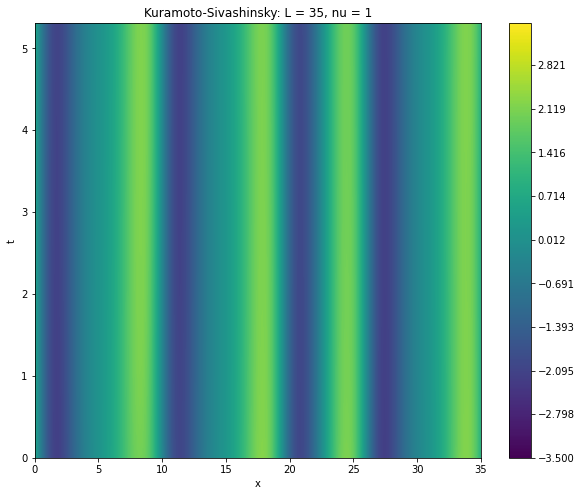

In [18]:
RPO2 = JAX_propagator(sol,T_new)
plot_KS(RPO2,T_new)

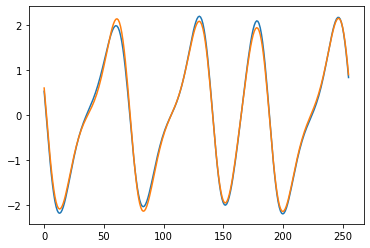

In [19]:
plt.plot(RPO2[0])
plt.plot(RPO2[-1])